# **Adapted Wasserstein Distance (Non-Markovian Case)**

This notebook presents how to compute the adapted Wasserstein distance in the non-Markovian case. Specifically, we consider 3D time dimension (`T = 3`). 

In [1]:
## Imports and Setup
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project structure)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

## Experiment Parameters

In [2]:
# Fixed Grid Size
fixed_grid = 0.01

# Sample Sizes
sample_sizes = [1000, 2000, 4000, 6000, 8000, 10000, 12000, 15000]

# Number of Runs per Sample Size
n_runs = 10

# Time Horizon (T)
T = 3  

# Define matrices (change these as needed for other experiments)
L = np.array([[1, 0, 0],
              [2, 4, 0],
              [3, 2, 1]])
M = np.array([[1, 0, 0],
              [2, 3, 0],
              [3, 1, 2]])

## Main Experiment Loop

In [3]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    # Arrays to hold the results of each run (1D arrays since grid is fixed)
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # New random seed for each run
        random_seed = np.random.randint(10000)
        
        # Generate sample paths (X for process 1 and Y for process 2)
        X, A = Lmatrix2paths(L, n_sample, seed=random_seed, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=random_seed, verbose=False)
        
        # Compute the theoretical benchmark (A and B depend solely on L and M)
        benchmark = adapted_wasserstein_squared(A, B)
        
        adaptedX = path2adaptedpath(X, delta_n = fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n = fixed_grid)
        
        # Quantization map
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}  # Value to Quantization

        # Quantized paths
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])

        # Sort paths and transpose to (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)

        # Get conditional distribution mu_{x_{1:t}} = mu_x[t][(x_1,...,x_t)] = {x_{t+1} : mu_{x_{1:t}}(x_{t+1}), ...}
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)

        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and time the computation
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")

    # Store results for this sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 205.83it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.13it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.91it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 197.78it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 207.36it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 23.62it/s]

 33%|███████████████                              | 3/9 [00:00<00:00, 21.46it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 51.24it/s]

 89%|████████████████████████████████████████     | 8/9 [00:00<00:00, 31.16it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.44it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.64it/s]


Sample size 1000, Run 1: AW_2^2 = 2.8529, Time = 2.7597 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 198.48it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 202.48it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 198.82it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.66it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 173.56it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.00it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 30.07it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 20.68it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 18.98it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.39it/s]


Sample size 1000, Run 2: AW_2^2 = 2.8013, Time = 2.6948 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 178.20it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.00it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 196.22it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 23.37it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 48.12it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.65it/s]


Sample size 1000, Run 3: AW_2^2 = 2.8288, Time = 2.7201 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 203.60it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 183.50it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 184.64it/s]

  0%|                                                    | 0/23 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.38it/s]


  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 28.36it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 67.90it/s]


Sample size 1000, Run 4: AW_2^2 = 3.1098, Time = 2.5409 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 190.18it/s]

 88%|████████████████████████████████████▊     | 21/24 [00:00<00:00, 209.08it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 167.44it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 195.88it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 188.64it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 360.58it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.03it/s]


Sample size 1000, Run 5: AW_2^2 = 3.0768, Time = 2.5296 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 198.08it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 200.00it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 202.26it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 192.00it/s]

 44%|████████████████████                         | 4/9 [00:00<00:00, 28.60it/s]

 44%|████████████████████                         | 4/9 [00:00<00:00, 39.35it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 21.90it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 48.20it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.34it/s]


Sample size 1000, Run 6: AW_2^2 = 2.8578, Time = 2.5906 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.52it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.56it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 194.63it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.91it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 27.13it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.37it/s]


Sample size 1000, Run 7: AW_2^2 = 2.9617, Time = 2.7321 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 194.33it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 208.83it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 50.31it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 26.70it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.10it/s]


Sample size 1000, Run 8: AW_2^2 = 3.0169, Time = 2.6746 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 205.55it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 189.65it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.59it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 197.23it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.75it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 167.40it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 185.09it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 20.89it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 40.37it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 31.04it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 116.65it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 23.55it/s]

100%|███████████

Sample size 1000, Run 9: AW_2^2 = 2.9998, Time = 2.6894 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 202.07it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 177.43it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 188.49it/s]

 91%|██████████████████████████████████████▎   | 21/23 [00:00<00:00, 209.77it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 195.21it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 202.18it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 22.93it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 25.28it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 29.93it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 25.46it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.62it/s]


Sample size 1000, Run 10: AW_2^2 = 2.8391, Time = 2.7722 s

Running experiments for sample size: 2000


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 92.11it/s]

 87%|████████████████████████████████████▋     | 41/47 [00:00<00:00, 100.50it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 15.31it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 15.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.48it/s]


Sample size 2000, Run 1: AW_2^2 = 2.9085, Time = 5.1343 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 97.19it/s]

 19%|████████▍                                   | 9/47 [00:00<00:00, 83.90it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 97.50it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 101.45it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 28.47it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Sample size 2000, Run 2: AW_2^2 = 2.9794, Time = 4.9850 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 94.50it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 90.78it/s]



100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 100.00it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.85it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.01it/s]


Sample size 2000, Run 3: AW_2^2 = 2.9823, Time = 4.9542 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 99.83it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 99.30it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 102.01it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.01it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.95it/s]


Sample size 2000, Run 4: AW_2^2 = 2.9490, Time = 5.5405 s


 21%|█████████▏                                 | 10/47 [00:00<00:00, 96.81it/s]

 43%|██████████████████▎                        | 20/47 [00:00<00:00, 93.21it/s]

 23%|█████████▊                                | 11/47 [00:00<00:00, 102.77it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 91.48it/s]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 16.72it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 18.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Sample size 2000, Run 5: AW_2^2 = 2.9274, Time = 5.3575 s


 69%|█████████████████████████████▌             | 33/48 [00:00<00:00, 99.68it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 98.34it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 94.00it/s]

 40%|█████████████████▌                          | 4/10 [00:00<00:00, 14.49it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Sample size 2000, Run 6: AW_2^2 = 2.9957, Time = 4.8399 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 89.50it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.59it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.25it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.66it/s]


Sample size 2000, Run 7: AW_2^2 = 2.9694, Time = 5.0217 s


 46%|███████████████████▎                      | 22/48 [00:00<00:00, 102.75it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 95.59it/s]


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.40it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 86.79it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.55it/s]

 36%|████████████████                            | 4/11 [00:00<00:00, 14.85it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 14.35it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.68it/s]


Sample size 2000, Run 8: AW_2^2 = 3.1152, Time = 4.8176 s


100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 93.01it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 98.13it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.76it/s]


Sample size 2000, Run 9: AW_2^2 = 3.0144, Time = 5.1068 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 96.95it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 104.13it/s]

 64%|███████████████████████████▍               | 30/47 [00:00<00:00, 97.91it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 98.56it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.02it/s]


Sample size 2000, Run 10: AW_2^2 = 3.0828, Time = 5.8155 s

Running experiments for sample size: 4000


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 41.75it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.08it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Sample size 4000, Run 1: AW_2^2 = 2.9169, Time = 12.6502 s


 74%|███████████████████████████████▋           | 70/95 [00:01<00:00, 41.73it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 45.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Sample size 4000, Run 2: AW_2^2 = 3.1206, Time = 14.5588 s


 48%|████████████████████▌                      | 45/94 [00:01<00:01, 41.99it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Sample size 4000, Run 3: AW_2^2 = 3.0071, Time = 14.0196 s


 82%|███████████████████████████████████▎       | 78/95 [00:01<00:00, 38.50it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Sample size 4000, Run 4: AW_2^2 = 3.0137, Time = 13.5550 s


 88%|██████████████████████████████████████     | 84/95 [00:02<00:00, 38.06it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 44.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


Sample size 4000, Run 5: AW_2^2 = 3.0352, Time = 14.8065 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 45.11it/s]

 75%|████████████████████████████████▏          | 71/95 [00:01<00:00, 43.84it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Sample size 4000, Run 6: AW_2^2 = 2.9669, Time = 14.0927 s


 65%|███████████████████████████▉               | 61/94 [00:01<00:00, 44.45it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 44.76it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Sample size 4000, Run 7: AW_2^2 = 2.9248, Time = 14.3333 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 44.96it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.72it/s]

 91%|██████████████████████████████████████▉    | 86/95 [00:02<00:00, 44.72it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.90it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 44.88it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Sample size 4000, Run 8: AW_2^2 = 3.0415, Time = 14.3024 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 41.04it/s]

 65%|████████████████████████████               | 62/95 [00:01<00:00, 43.03it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 39.74it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 14.47it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Sample size 4000, Run 9: AW_2^2 = 3.0552, Time = 14.4468 s


 83%|███████████████████████████████████▊       | 79/95 [00:01<00:00, 37.02it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Sample size 4000, Run 10: AW_2^2 = 2.9757, Time = 14.3461 s

Running experiments for sample size: 6000


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Sample size 6000, Run 1: AW_2^2 = 3.0115, Time = 24.0466 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.51it/s]

 85%|██████████████████████████████████▉      | 121/142 [00:04<00:00, 30.38it/s]

100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.80it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Sample size 6000, Run 2: AW_2^2 = 2.9713, Time = 23.7437 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Sample size 6000, Run 3: AW_2^2 = 3.0493, Time = 27.3553 s


 48%|████████████████████                      | 68/142 [00:02<00:02, 27.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Sample size 6000, Run 4: AW_2^2 = 2.9851, Time = 27.4093 s


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.85it/s]

 85%|██████████████████████████████████▉      | 121/142 [00:04<00:00, 30.64it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 29.13it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Sample size 6000, Run 5: AW_2^2 = 2.9463, Time = 27.1211 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Sample size 6000, Run 6: AW_2^2 = 3.0500, Time = 27.3941 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Sample size 6000, Run 7: AW_2^2 = 3.0237, Time = 27.1566 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Sample size 6000, Run 8: AW_2^2 = 2.9537, Time = 27.2756 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Sample size 6000, Run 9: AW_2^2 = 2.9755, Time = 27.8445 s


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.14it/s]

 82%|█████████████████████████████████▍       | 116/142 [00:04<00:00, 30.79it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.16it/s]


Sample size 6000, Run 10: AW_2^2 = 2.9974, Time = 27.3083 s

Running experiments for sample size: 8000


100%|█████████████████████████████████████████| 189/189 [00:08<00:00, 21.09it/s]

100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.11it/s]

100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 19.86it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Sample size 8000, Run 1: AW_2^2 = 3.0571, Time = 45.8033 s


 99%|████████████████████████████████████████▌| 187/189 [00:09<00:00, 22.28it/s]


100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.79it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Sample size 8000, Run 2: AW_2^2 = 3.0455, Time = 45.1451 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Sample size 8000, Run 3: AW_2^2 = 2.9697, Time = 45.5784 s


 86%|███████████████████████████████████▎     | 163/189 [00:08<00:01, 20.78it/s]

100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.62it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


Sample size 8000, Run 4: AW_2^2 = 3.0042, Time = 45.5064 s


 81%|█████████████████████████████████▏       | 153/189 [00:07<00:01, 21.19it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Sample size 8000, Run 5: AW_2^2 = 3.0500, Time = 45.0170 s


 78%|████████████████████████████████         | 147/188 [00:07<00:01, 20.66it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Sample size 8000, Run 6: AW_2^2 = 3.0307, Time = 47.4735 s


100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 19.80it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Sample size 8000, Run 7: AW_2^2 = 2.9967, Time = 46.3722 s


100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Sample size 8000, Run 8: AW_2^2 = 3.0037, Time = 45.4082 s


100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.40it/s]

100%|█████████████████████████████████████████| 189/189 [00:09<00:00, 20.48it/s]

 89%|████████████████████████████████████▍    | 168/189 [00:08<00:00, 21.76it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Sample size 8000, Run 9: AW_2^2 = 3.0320, Time = 47.1499 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]


Sample size 8000, Run 10: AW_2^2 = 3.0087, Time = 45.1205 s

Running experiments for sample size: 10000


100%|█████████████████████████████████████████| 236/236 [00:15<00:00, 15.48it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Sample size 10000, Run 1: AW_2^2 = 3.1064, Time = 64.0875 s


 89%|████████████████████████████████████▍    | 209/235 [00:13<00:01, 17.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Sample size 10000, Run 2: AW_2^2 = 3.0129, Time = 63.2329 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Sample size 10000, Run 3: AW_2^2 = 3.0434, Time = 62.6920 s


100%|█████████████████████████████████████████| 236/236 [00:14<00:00, 16.39it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Sample size 10000, Run 4: AW_2^2 = 3.0365, Time = 68.0152 s


100%|█████████████████████████████████████████| 235/235 [00:14<00:00, 16.25it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Sample size 10000, Run 5: AW_2^2 = 2.9827, Time = 71.5631 s


100%|█████████████████████████████████████████| 235/235 [00:15<00:00, 15.53it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Sample size 10000, Run 6: AW_2^2 = 2.9668, Time = 71.1675 s


100%|█████████████████████████████████████████| 236/236 [00:15<00:00, 15.62it/s]

100%|█████████████████████████████████████████| 235/235 [00:14<00:00, 15.76it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.45it/s]


Sample size 10000, Run 7: AW_2^2 = 2.9569, Time = 66.9339 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Sample size 10000, Run 8: AW_2^2 = 3.0537, Time = 70.5801 s


 99%|████████████████████████████████████████▋| 233/235 [00:14<00:00, 20.54it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Sample size 10000, Run 9: AW_2^2 = 3.0642, Time = 68.9287 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Sample size 10000, Run 10: AW_2^2 = 3.0136, Time = 69.8519 s

Running experiments for sample size: 12000


 96%|███████████████████████████████████████▎ | 270/282 [00:20<00:00, 13.43it/s]

100%|█████████████████████████████████████████| 283/283 [00:21<00:00, 13.38it/s]

100%|█████████████████████████████████████████| 282/282 [00:21<00:00, 13.32it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Sample size 12000, Run 1: AW_2^2 = 2.9635, Time = 97.5654 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Sample size 12000, Run 2: AW_2^2 = 3.0388, Time = 103.4411 s


100%|█████████████████████████████████████████| 282/282 [00:21<00:00, 13.38it/s]

100%|█████████████████████████████████████████| 282/282 [00:20<00:00, 13.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.57it/s]


Sample size 12000, Run 3: AW_2^2 = 3.0404, Time = 95.8111 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.48it/s]


Sample size 12000, Run 4: AW_2^2 = 2.9372, Time = 101.3945 s


100%|█████████████████████████████████████████| 282/282 [00:21<00:00, 13.22it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Sample size 12000, Run 5: AW_2^2 = 3.0181, Time = 100.2911 s


100%|█████████████████████████████████████████| 283/283 [00:20<00:00, 13.48it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Sample size 12000, Run 6: AW_2^2 = 3.0400, Time = 91.2752 s


100%|█████████████████████████████████████████| 282/282 [00:21<00:00, 13.32it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Sample size 12000, Run 7: AW_2^2 = 3.0625, Time = 96.2548 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Sample size 12000, Run 8: AW_2^2 = 2.9939, Time = 102.6013 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Sample size 12000, Run 9: AW_2^2 = 2.9915, Time = 99.5768 s


100%|█████████████████████████████████████████| 283/283 [00:20<00:00, 13.57it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.96it/s]


Sample size 12000, Run 10: AW_2^2 = 3.0418, Time = 99.8763 s

Running experiments for sample size: 15000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Sample size 15000, Run 1: AW_2^2 = 3.0248, Time = 142.3885 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Sample size 15000, Run 2: AW_2^2 = 3.0248, Time = 135.5059 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Sample size 15000, Run 3: AW_2^2 = 3.0366, Time = 134.2168 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Sample size 15000, Run 4: AW_2^2 = 3.0015, Time = 134.7215 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Sample size 15000, Run 5: AW_2^2 = 3.0648, Time = 137.7903 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.56it/s]


Sample size 15000, Run 6: AW_2^2 = 3.0999, Time = 138.1490 s


100%|█████████████████████████████████████████| 353/353 [00:31<00:00, 11.14it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Sample size 15000, Run 7: AW_2^2 = 3.0198, Time = 139.9349 s


 96%|███████████████████████████████████████▎ | 338/352 [00:31<00:01, 11.98it/s]

100%|█████████████████████████████████████████| 352/352 [00:32<00:00, 10.90it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Sample size 15000, Run 8: AW_2^2 = 2.9990, Time = 139.7655 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Sample size 15000, Run 9: AW_2^2 = 3.1030, Time = 140.4387 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Sample size 15000, Run 10: AW_2^2 = 3.0285, Time = 143.3028 s


## Results Analysis and Plotting

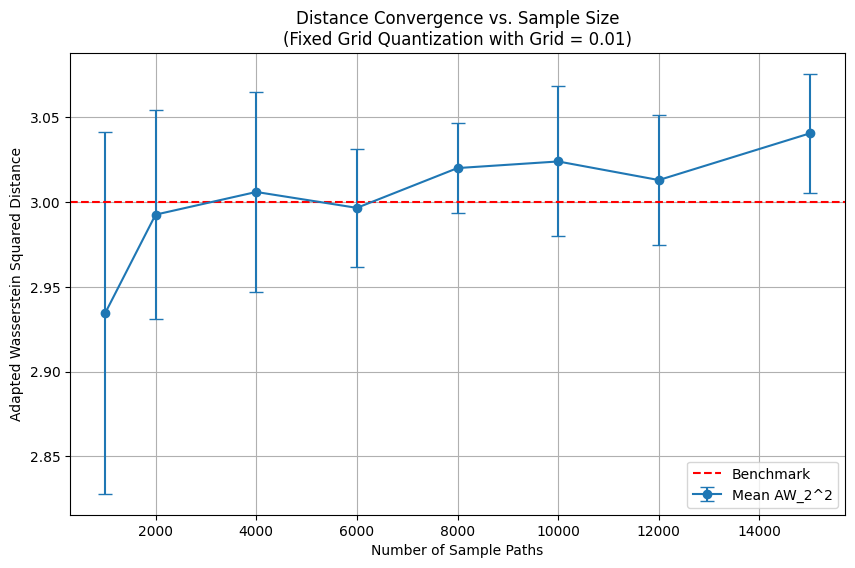

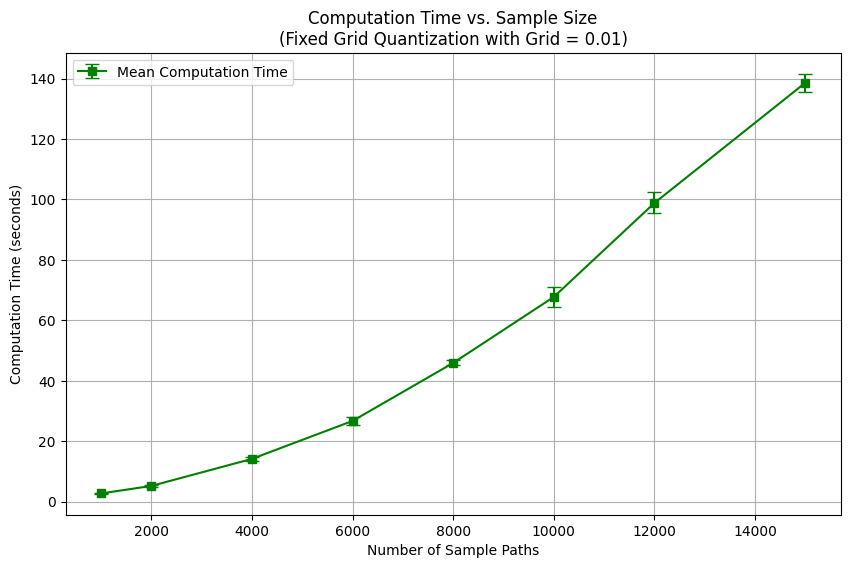

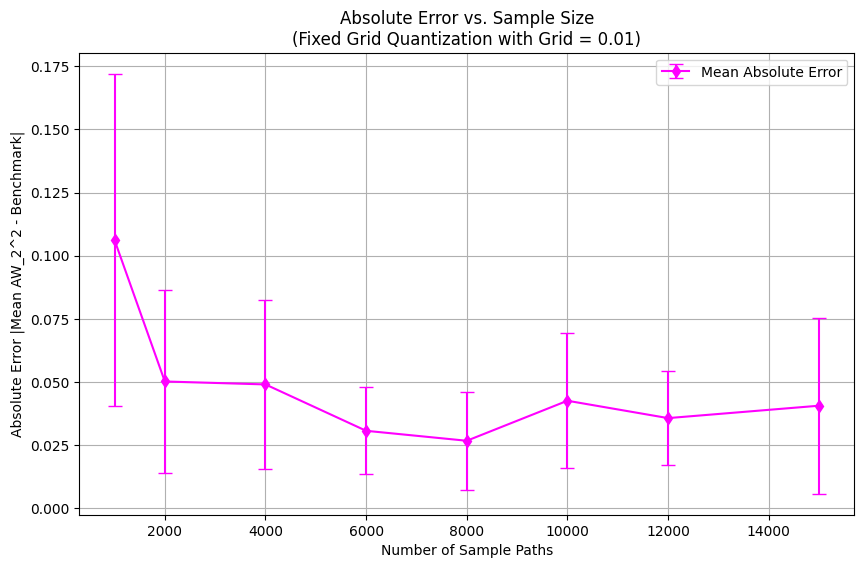

In [4]:
sample_list = sorted(results.keys())
mean_distances = []
std_distances = []
mean_times = []
std_times = []
mean_abs_errors = []
std_abs_errors = []
benchmarks = []  # (should be the same for all runs)

for n_sample in sample_list:
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))
    abs_errors = np.abs(dists - bench)
    mean_abs_errors.append(np.mean(abs_errors))
    std_abs_errors.append(np.std(abs_errors))
    benchmarks.append(bench)


# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmarks[0], color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|")
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()